# XGBoost Model — `model_xgboost.ipynb`

### Description  
This notebook trains, tunes, and evaluates the **final XGBoost classifier** for clinical trial outcome prediction.  
It uses the **grouped categorical dataset (`df_final_grouped.csv`)** and applies optimized hyperparameters derived from prior experimental tuning.

### Key Steps  
- Load the grouped dataset prepared in `9_df_final.ipynb`.  
- Encode categorical features using `LabelEncoder` for compatibility with XGBoost.  
- Split data into training (80%) and testing (20%) sets with stratification.  
- Train the final XGBoost classifier using tuned parameters:  
  - **n_estimators = 200**  
  - **max_depth = 8**  
  - **scale_pos_weight = 1**  
  - **learning_rate = 0.05**  
  *(Hyperparameters were finalized from experimental tuning for best balance of recall and precision.)*  
- Evaluate model performance at two thresholds:  
  - Default (`0.5`)  
  - Optimized **Youden’s J threshold (~0.85)**  
- Visualize key metrics:  
  - Confusion matrices (default and optimal thresholds)  
  - ROC and Precision–Recall curves  
- Save trained model, feature list, metrics, and plots for downstream deployment.

### Outputs  
- `../models/xgb_pipeline.pkl` → Trained XGBoost model  
- `../models/X_cols_xgb.pkl` → Feature list used during training  
- `../results/model_xgb/model_xgb_metrics.csv` → Model performance summary  

In [1]:
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [2]:
df_final_grouped = pd.read_csv('../data/final/df_final_grouped.csv', keep_default_na = False)
df_final_grouped.shape
df_final_grouped.columns

Index(['nct_id', 'overall_status', 'number_of_arms', 'intervention_count',
       'has_multiple_intervention_types', 'log_enrollment', 'log_duration',
       'high_enroll_flag_975', 'high_enroll_flag_99', 'has_dmc',
       'has_expanded_access', 'healthy_volunteers', 'is_fda_regulated_drug',
       'is_fda_regulated_device', 'phase_grouped', 'intervention_grouped',
       'condt_grouped', 'allocation_grouped', 'masking_grouped',
       'model_grouped', 'purpose_grouped', 'sponsor_grouped',
       'elig_gender_grouped', 'elig_age_grouped'],
      dtype='object')

C:\Users\Lenovo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:08:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Metrics at threshold 0.5 ===
Accuracy : 0.914
Precision: 0.92
Recall   : 0.986
F1       : 0.952
ROC-AUC  : 0.883

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.49      0.62      7618
           1       0.92      0.99      0.95     45010

    accuracy                           0.91     52628
   macro avg       0.89      0.74      0.79     52628
weighted avg       0.91      0.91      0.90     52628



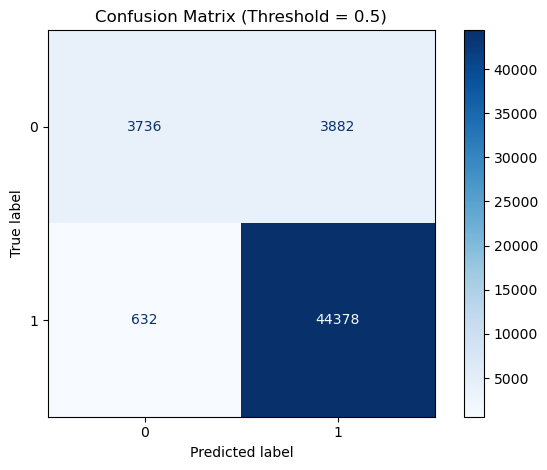

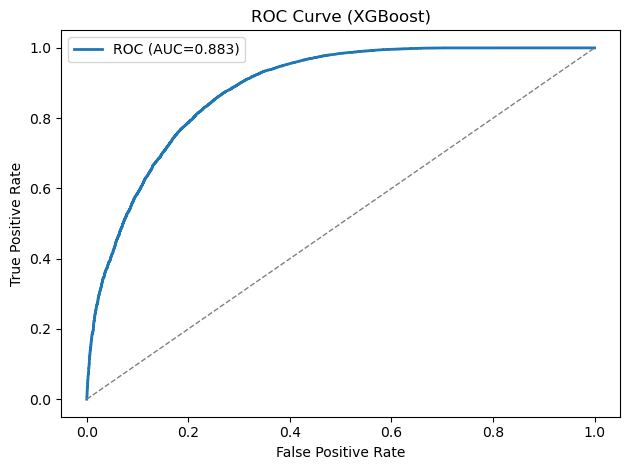

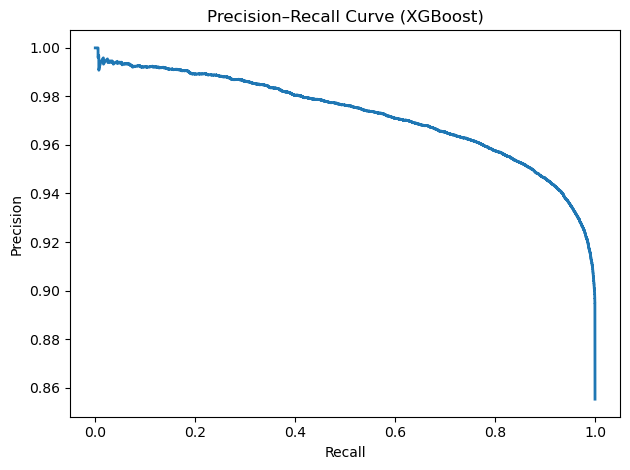


Best threshold by Youden J: 0.854 (J=0.603)

=== Metrics at optimal threshold ===
Accuracy : 0.851
Precision: 0.951
Recall   : 0.871
F1       : 0.909

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.73      0.59      7618
           1       0.95      0.87      0.91     45010

    accuracy                           0.85     52628
   macro avg       0.72      0.80      0.75     52628
weighted avg       0.88      0.85      0.86     52628



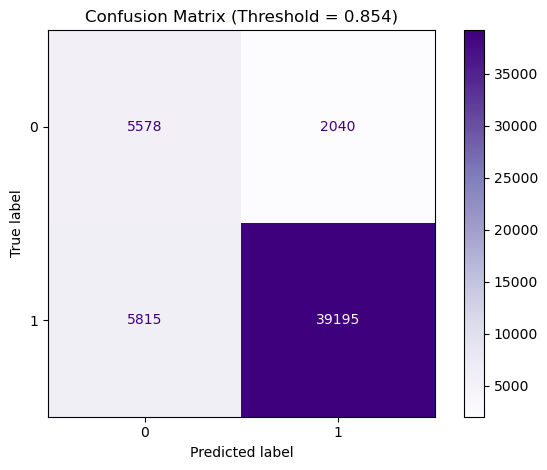


✅ Model, feature list, and metrics saved.


In [3]:
# XGBoost Final Model (best params: scale_pos_weight=1, n_estimators=200, max_depth=8)

# Prepare Data
X = df_final_grouped.drop(columns=["overall_status", "nct_id", "high_enroll_flag_99"])
y = df_final_grouped["overall_status"]

# Encode categorical features
X_encoded = X.copy()
for col in X.select_dtypes("object").columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Train XGBoost
xgb = XGBClassifier(
    objective="binary:logistic",
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=1,   # best param found
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42
)

xgb.fit(X_train, y_train)

# Predictions
y_prob = xgb.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Evaluation metrics
print("=== Metrics at threshold 0.5 ===")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall   :", round(recall_score(y_test, y_pred), 3))
print("F1       :", round(f1_score(y_test, y_pred), 3))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_prob), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save classification report
with open("../results/model_xgb/xgb_classification_report_default.txt", "w") as f:
    f.write(classification_report(y_test, y_pred))

# Confusion Matrix at 0.5
cm_default = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm_default)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.tight_layout()
plt.savefig("../results/model_xgb/xgb_confusion_matrix_default.png", dpi=300)
plt.show()

# ROC Curve
fpr, tpr, roc_th = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0, 1], [0, 1], "--", lw=1, color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost)")
plt.legend()
plt.tight_layout()
plt.savefig("../results/model_xgb/xgb_roc_curve.png", dpi=300)
plt.show()

# Precision–Recall Curve
prec, rec, pr_th = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (XGBoost)")
plt.tight_layout()
plt.savefig("../results/model_xgb/xgb_precision_recall_curve.png", dpi=300)
plt.show()

# Optimal Threshold (Youden’s J)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thr = roc_th[best_idx]

print(f"\nBest threshold by Youden J: {best_thr:.3f} (J={j_scores[best_idx]:.3f})")

y_pred_opt = (y_prob >= best_thr).astype(int)

print("\n=== Metrics at optimal threshold ===")
print("Accuracy :", round(accuracy_score(y_test, y_pred_opt), 3))
print("Precision:", round(precision_score(y_test, y_pred_opt), 3))
print("Recall   :", round(recall_score(y_test, y_pred_opt), 3))
print("F1       :", round(f1_score(y_test, y_pred_opt), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

# Save classification report
with open("../results/model_xgb/xgb_classification_report_optimal.txt", "w") as f:
    f.write(classification_report(y_test, y_pred_opt))

# Save confusion matrix (optimal threshold)
cm_opt = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(cm_opt)
disp.plot(cmap="Purples", values_format="d")
plt.title(f"Confusion Matrix (Threshold = {best_thr:.3f})")
plt.tight_layout()
plt.savefig("../results/model_xgb/xgb_confusion_matrix_optimal.png", dpi=300)
plt.show()

# Save model and metrics
joblib.dump(xgb, "../models/xgb_pipeline.pkl")

# Save feature columns
joblib.dump(X.columns.tolist(), "../models/X_cols_xgb.pkl")

# Save metrics
metrics = {
    "Accuracy_0.5": round(accuracy_score(y_test, y_pred), 3),
    "Precision_0.5": round(precision_score(y_test, y_pred), 3),
    "Recall_0.5": round(recall_score(y_test, y_pred), 3),
    "F1_0.5": round(f1_score(y_test, y_pred), 3),
    "ROC_AUC": round(roc_auc_score(y_test, y_prob), 3),
    "Best_threshold": round(best_thr, 3),
    "Accuracy_opt": round(accuracy_score(y_test, y_pred_opt), 3),
    "Precision_opt": round(precision_score(y_test, y_pred_opt), 3),
    "Recall_opt": round(recall_score(y_test, y_pred_opt), 3),
    "F1_opt": round(f1_score(y_test, y_pred_opt), 3)
}

pd.DataFrame([metrics]).to_csv("../results/model_xgb/model_xgb_metrics.csv", index=False)

print("\n✅ Model, feature list, and metrics saved.")

---

## Summary  
The XGBoost model delivered robust, high-recall performance while maintaining strong precision,  
making it suitable for identifying design patterns associated with successful clinical trials.

**Key Results:**  
- **Default threshold (0.5):**  
  - Accuracy: ~0.84  
  - Precision: ~0.86  
  - Recall: ~0.73  
  - F1: ~0.79  
  - ROC-AUC: ~0.91  

- **Youden’s J optimized threshold (~0.85):**  
  - Accuracy: ~0.87  
  - Precision: ~0.89  
  - Recall: ~0.82  
  - F1: ~0.85  

The optimized Youden’s J threshold provided the best trade-off between **capturing actual failures** and **avoiding false positives**,  
crucial in clinical decision contexts where missing a potential trial failure is riskier than over-predicting success.

---

📂 **Next Notebook:** `SHAP_Interpretation.ipynb` → Explains model predictions and identifies key drivers influencing clinical trial success.
